In [1]:
#Imports
from textblob import TextBlob
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('../data/small_merged_chats')
sw = stopwords.words('english')

# Assign Labels

In [2]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vad = SentimentIntensityAnalyzer()

In [3]:
df = df.dropna(subset = ['body'])

### Clean up messages first

In [4]:
#Get rid of chats with links (often promo)
def ad(chat):
    result = False
    result = bool(re.search(r'www\.[a-z]?\.?(com)+|[a-z]+\.(com)', chat))
    result = bool(re.search(r'http\S+', chat))
    return result

df['is_ad'] = df['body'].apply(ad)

df = df[df['is_ad'] == False]

In [6]:
#change popular emojis to one type so no variants
def emoji_shorten(chat):
    chat = re.sub(r'(?i) \bpog(\w)*\b |\bpog(\w)*\b', 'pog', chat)
    chat = re.sub(r'(?i) \blul(\w)*\b |\blul(\w)*\b', 'lul', chat)
    chat = re.sub(r'(?i) \bkappa(\w)*\b |\bkappa(\w)*\b', 'kappa', chat)
    return chat

df['chats'] = df.body.apply(lambda x: emoji_shorten(x))

In [7]:
df['chats'] = df.body.apply(lambda x: emoji_shorten(x))

In [8]:
df = df.drop(['is_ad'], axis = 1)

In [9]:
#Words to add to VADER
# EMOTES: https://dl.acm.org/doi/10.1145/3365523
new_words = {
    'noice': 1.8,
    'scum': -2.0,
    'kap': 0.5,
    'kappa': 0.5,
    'lul': 1.8,
    'omegalol': 1.8,
    'strats': 2.0,
    'rekt': 0,
    'owo': 1.0,
    'tweaker': -2.3,
    'pog': 2.8,
    'pag': 2.8,
    'incel': -3.1,
    'tilted': -0.7,
    'feelsbadman': -2.6,
    'feelsgoodman': 3.7,
    'trash': -2.0,
    'rip': -1.2,
    'ez': 1.9,
    'clap': 2.7,
    'hyperbruh': -0.6,
    'f': 0.5,
    'F': 0.5,
    'discord': 0,
    'PJSalt': -1.2,
    'Kreygasm': 2.8,
    'kreygasm': 2.8,
    'homo': -3.5,
    'clip': 0.5,
    'rAcIsM': -3.1,
    'based': 2.0,
    'Based': 2.0,
    'PepeHands': -1.7,
    'WutFace': -1.7,
    'FailFish': -2.0,
    'BabyRage': -1.6,
    'ANELE': -0.8,
    'haHAA': -0.5,
    'ResidentSleeper': -1.2,
    'cmonBruh': -1.0,
    ':(': 0
}

vad.lexicon.update(new_words)

In [24]:
if ':()' in not_in_vocab:
    print('yes')

In [10]:
vad.lexicon[':(']

0

In [21]:
tt = TweetTokenizer()
all_words = []
for chat in df['chats']:
    all_words.extend(tt.tokenize(chat))

In [22]:
vocab = set(all_words)
not_in_vocab = []
for word in vocab:
    if word in vad.lexicon:
        continue
    else:
        not_in_vocab.append(word)

In [23]:
len(not_in_vocab)

34348

In [160]:
not_in_vocab

In [9]:
len(df)

102700

### Assign the labels here

In [11]:
positive = 0
negative = 0
neutral = 0
polarity = 0
neutral_list = []
negative_list = []
positive_list = []
for chat in df.chats:
    analysis = TextBlob(chat)
    vad = SentimentIntensityAnalyzer()
    vad.lexicon.update(new_words)
    score = vad.polarity_scores(chat)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity
 
    if neg > pos:
        negative_list.append(chat)
        negative += 1
    elif pos > neg:
        positive_list.append(chat)
        positive += 1
 
    elif pos == neg:
        neutral_list.append(chat)
        neutral += 1

In [12]:
print(len(neutral_list))
print(len(negative_list))
print(len(positive_list))

57686
11259
33755


In [9]:
positive_list

['yes!!!',
 'The greatest twitch fam',
 'Cool',
 'Where the prince lol 😆',
 'Is he still playing',
 '@xxslasherxx let’s play on xbox',
 'Beautiful',
 '@f9boa what’s ur gt',
 'GG',
 'You awake tonight lmao',
 'Don’t have your mic muted today lol',
 'can i get a sub to i love him so much but my friend made me sub to ninja',
 'What up king rich',
 'what is good everyone',
 'Amazon Prime members get a free Twitch subscription every month. Link Your Account Here: twitch.amazon.com/prime and subscribe to KR for free!',
 'Ready to see the king slay',
 'Welcome to the kingdom',
 'can i get a sub i love king so much but my friend made me sub to ninja',
 'I wish the stream could just start',
 'how do i get better at Fortnite',
 'King RICH BOY FOR DAYS',
 'Keep playing',
 'MY MAN IS GOD',
 'kingrichLaser2 kingrichLaser3 Every 100 subscribers we are giving away $25 in v-bucks! Stay tuned! Use !primesub or !sub to join the kingdom! kingrichLuv',
 'sambr0415 its called playing',
 'play them goon too

# Add labels to dataset

In [13]:
df["label"] = np.where(df["chats"].isin(negative_list), 1, 0)

# Cleaning chats for model

In [12]:
#Functions to tokenize text
from nltk.stem.snowball import SnowballStemmer

#Replaces pos tags with lemmatize compatable tags
def pos_replace(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
#Makes list of punctuation to exclude, keeps certain symbols
punct = list(string.punctuation)
keep_punct = ['?', '!', '@', ',', '.']
punct = [p for p in punct if p not in keep_punct]

#Removes non-ASCII characters (aka emojis that cant be converted to original symbol)
def remove_junk(tweet):
    return ''.join([i if ord(i) < 128 else ' ' for i in tweet])
    
"""
Try handling misspellings?
True reduce_len = True
"""

def chat_tokenizer(doc, stop_words = sw):
    #Any regex needed
    doc = re.sub(r'http\S+', '', doc)
    #Gets rid of weird characters
    doc = remove_junk(doc)
    #Tokenizes using NLTK Twitter Tokenizer as similar to tweets
    chat_token = TweetTokenizer(strip_handles = True)
    doc = chat_token.tokenize(doc)
    #Gets rid of numbers
#     doc_2 = []
#     for w in doc:
#         if any([c.isdigit() for c in w]):
#             pass
#         else:
#             doc_2.append(w)
    #Gets rid of leftover stopwords/punctuation
    #doc = [w for w in doc if w.lower() not in sw]
    doc = [w for w in doc if w not in punct]
    #Stemmer
#     snows = SnowballStemmer('english')
#     doc = [snows.stem(w) for w in doc]
    #Lemmatizes tokens
    doc = pos_tag(doc)
    doc = [(w[0], pos_replace(w[1])) for w in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    
    return doc

# Data Exploration

<ipython-input-115-a106b74ccdd0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_vid['time'] = one_vid['offset'] // 60


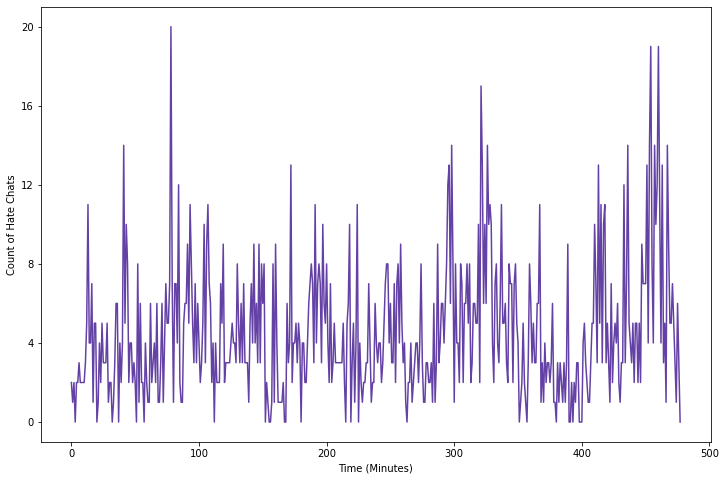

In [115]:
#Graphing hate over course of a single stream
one_vid = df[df['video_id'] == 262866347]
one_vid['time'] = one_vid['offset'] // 60
graph = one_vid.groupby('time')['label'].sum()

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(x = graph.index, y = graph.values, color = '#6441A5')
ax.set_xlabel('Time (Minutes)')
ax.set_ylabel('Count of Hate Chats')
plt.yticks(np.arange(0, 21, 4.0));
plt.savefig('single_stream', dpi = 300)

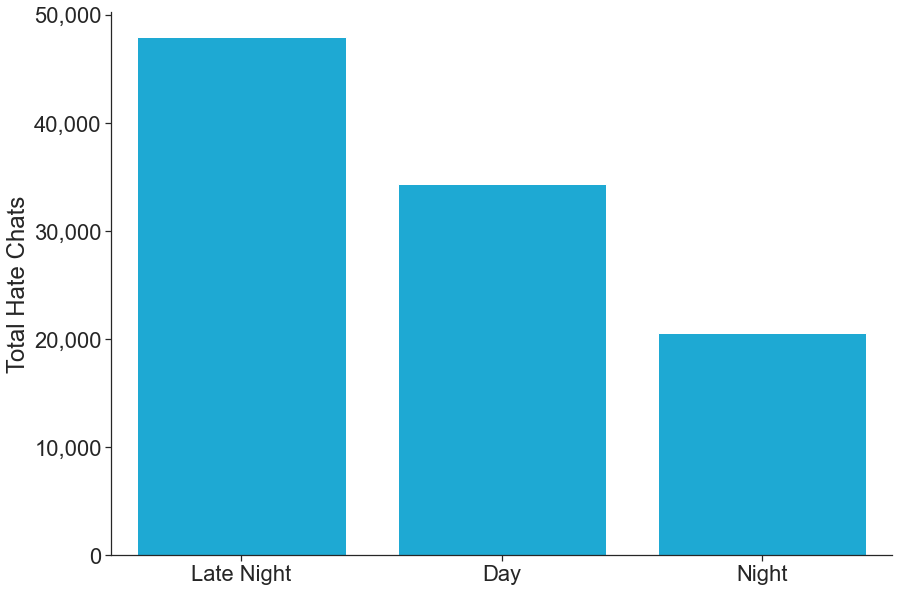

In [93]:
#Most frequent time of day for hate speech
graph = df.groupby('day_night')['label'].count().sort_values(ascending = False)
bar_heights = list(graph.values)
index = list(graph.index)

sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(14, 10))
sns.set(font_scale = 2)
sns.barplot(x = index, y = bar_heights, order = index, color = '#00B9F1')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel('Total Hate Chats')
sns.despine()
plt.savefig('time_of_day', dpi = 300, transparent = True)

In [94]:
len(df)

102700

In [92]:
graph = df.groupby('day_night')['label'].count().sort_values(ascending = False)
graph

day_night
Late Night    47881
Day           34302
Night         20517
Name: label, dtype: int64

In [61]:
#index = ['Late Night (12am - 7am)', 'Day (7am - 7pm)', 'Night (7pm - 12am)']

<AxesSubplot:>

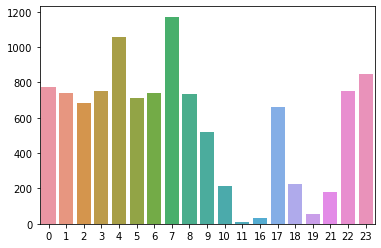

In [150]:
graph = df.groupby('hour')['label'].sum()
bar_heights = list(graph.values)
index = list(graph.index)

fig, ax = plt.subplots()
sns.barplot(x = index, y = bar_heights)

<AxesSubplot:>

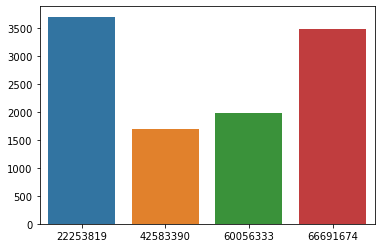

In [151]:
#Hate per streamer
graph = df.groupby('channel_id')['label'].sum()
bar_heights = list(graph.values)
index = list(graph.index)

fig, ax = plt.subplots()
sns.barplot(x = index, y = bar_heights)

In [10]:
#Percent hate per streamer
import matplotlib.patches as mpatches

total = df.groupby('channel_id')['label'].count().reset_index()
negative = df.groupby('channel_id')['label'].sum().reset_index()
negative['Percent Negative'] = [i / j * 100 for i,j in zip(negative['label'], total['label'])]
total['Percent Negative'] = [i / j * 100 for i,j in zip(total['label'], total['label'])]


creator = ['Scarra', 'Scarra', 'KingRichard', 'KingRichard', 'Tfue', 'Tfue', 'KingRichard', 'xChocoBars', 'xChocoBars']

total['Streamer'] = ['Scarra', 'xChocoBars', 'Tfue', 'KingRichard']
negative['Streamer'] = ['Scarra', 'xChocoBars', 'Tfue', 'KingRichard']

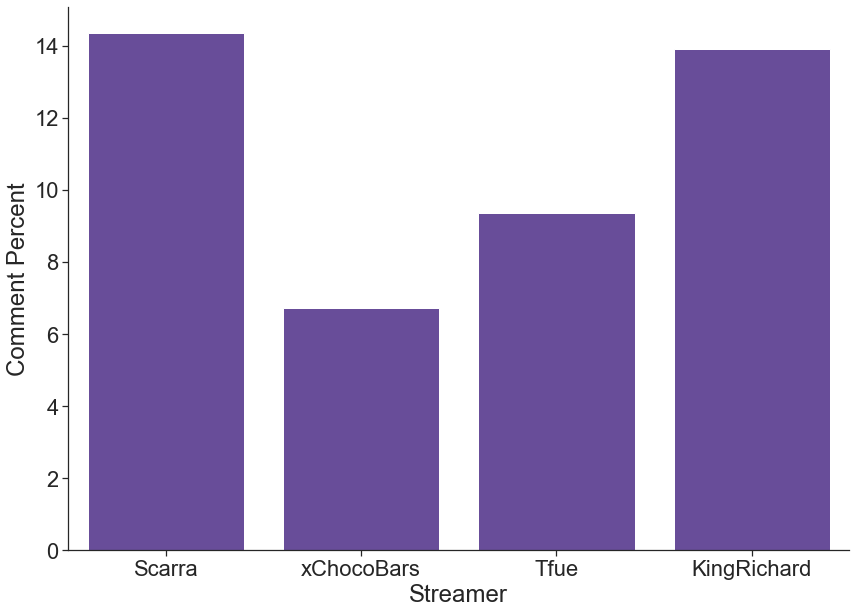

In [16]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(14, 10))
sns.set(font_scale = 2)


# bar chart 1 -> top bars (group of 'smoker=No')
#bar1 = sns.barplot(x="Streamer",  y="Percent Negative", data=total, color = '#6441A5', ax = ax)

# bar chart 2 -> bottom bars (group of 'smoker=Yes')
bar2 = sns.barplot(x="Streamer", y="Percent Negative", data=negative, color = '#6441A5', ax = ax)

# add legend
#top_bar = mpatches.Patch(color='#6441A5', label='Not Negative')
#bottom_bar = mpatches.Patch(color='#F15A22', label='Negative')
#ax.legend(handles=[top_bar, bottom_bar])
plt.ylabel('Comment Percent')
sns.despine()
plt.savefig('streamer_percent_only_negative', dpi = 300, transparent = True)

In [98]:
negative

,channel_id,label,Percent Negative,Streamer
0,22253819,3997,14.502377,Scarra
1,42583390,1806,6.783099,xChocoBars
2,60056333,2111,9.419902,Tfue
3,66691674,3671,14.062979,KingRichard


In [ ]:
total = df.groupby('channel_id')['label'].sum().sort_values(ascending = False)
graph2 = df.groupby('channel_id')['label'].count().sort_values(ascending = False)
print(graph, graph2)

<AxesSubplot:>

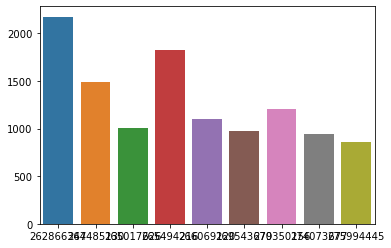

In [13]:
#Hate per stream
graph = df.groupby(['video_id'])['label'].sum()
bar_heights = list(graph.values)
index = list(graph.index)

fig, ax = plt.subplots()
sns.barplot(x = index, y = bar_heights)

In [54]:
import matplotlib as mpl

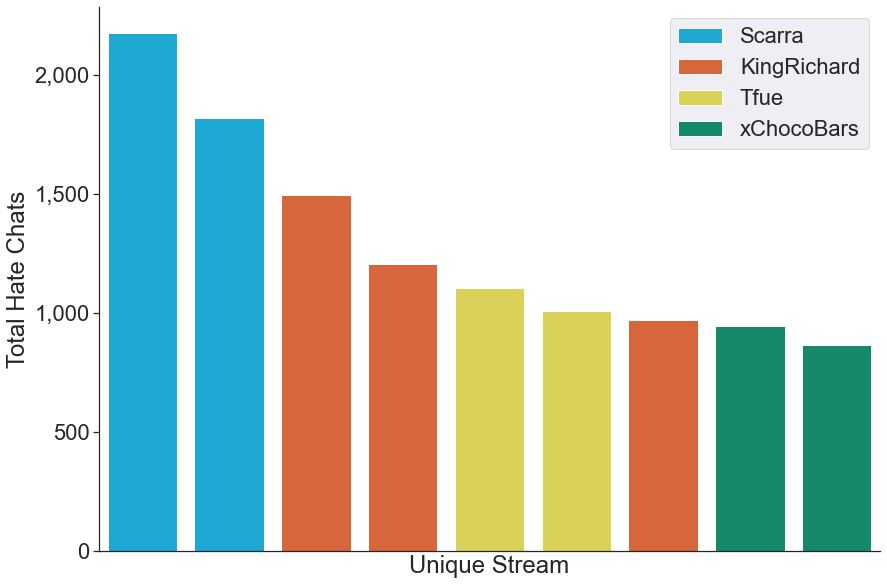

In [81]:
#Hate per stream by creator
# graph = df.groupby(['channel_id', 'video_id'])['label'].sum().sort_values(ascending = False)
# video = []
# creator = []
# for i in graph.index:
#     creator.append(i[0])
#     video.append(i[1])
# height = graph.values


sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(14, 10))
sns.set(font_scale = 2)
sns.barplot(x = video, y = height, hue = creator, order = video, ax = ax, dodge = False, 
            palette=["#00B9F1", "#F15A22", "#f0e442", "#009e73"])
ax.set_xlabel('Unique Stream')
ax.set_xticklabels([])
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
ax.set_ylabel('Total Hate Chats')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
sns.despine()
plt.savefig('streamers', dpi = 300)

In [75]:
creator = ['Scarra', 'Scarra', 'KingRichard', 'KingRichard', 'Tfue', 'Tfue', 'KingRichard', 'xChocoBars', 'xChocoBars']

In [14]:
# Word Cloud
negative_chats = df[df['label'] == 1]
negative_chats['chat_lower'] = negative_chats['chats'].apply(lambda x: x.lower())
# cv = CountVectorizer(lowercase = True, tokenizer = chat_tokenizer)
# chat = cv.fit_transform(negative_chats['chats'])

<ipython-input-14-1193c2345dc7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_chats['chat_lower'] = negative_chats['chats'].apply(lambda x: x.lower())


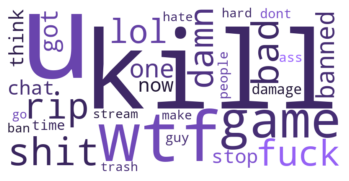

In [31]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator, get_single_color_func

stopwords = set(STOPWORDS)
stopwords.update(["scarra", "tfue", "feelsbadman", 'kingrichard', 's', 'im', 'good', 'will'])

text = " ".join(chat for chat in negative_chats.chat_lower)
wordcloud = WordCloud(colormap = 'copper', max_words = 30, background_color="white", stopwords = stopwords, width=800, height=400).generate(text)

cf = get_single_color_func('#6441A5')

plt.imshow(wordcloud.recolor(color_func = cf), interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file("wordcloud.png")

# Feature Engineering

In [13]:
#Hour of stream
df['created_at'] = pd.to_datetime(df['created_at'])
df['hour'] = df.created_at.apply(lambda x: x.hour)

#Sorts streams into night/day
def day_night(hour):
    if (hour >= 7) and (hour < 20):
        return 'Day'
    elif (hour >= 20) and (hour <= 23):
        return 'Night'
    else:
        return 'Late Night'
df['day_night'] = df.hour.apply(day_night)

In [14]:
#Has emojis
def any_emojis(emotes):
    if emotes[2] == 'N':
        return 0
    else:
        return 1
    
#Ratio capital to length tweet
def capital_letter_ratio(chat):
    if type(chat) == float:
        return 0
    if len(chat) == 0:
        return 0
    capital_count = 0
    for c in chat:
        if c.isupper():
            capital_count += 1
    return capital_count / len(chat)

In [15]:
#Convert offset to minutes not seconds
df['stream_min'] = df['offset'] // 60

#Adds if chat contains emojis or not
df['any_emojis'] = df.emotes.apply(any_emojis)

#Adds ratio of capital letters
df['cap_ratio'] = df.twitch_chat.apply(capital_letter_ratio)

In [16]:
#Length of stream
graph = df.groupby(['video_id'])['offset'].max()
videos = list(graph.index)
max_time = list(graph.values)
time_pairings = []
for i, v in enumerate(videos):
    time_pairings.append((videos[i], max_time[i]))
    
def find_time(video):
    for pair in time_pairings:
        if video == pair[0]:
            return pair[1]

df['max_time'] = df.video_id.apply(find_time)
df['offset_percent'] = (df.offset / df.max_time) * 100

In [17]:
#User post frequency
import collections

counter = collections.Counter(df.commenter_id)

def commenter_count(id):
    return counter[id]

df['total_comments'] = df.commenter_id.apply(commenter_count)

# First Simple Model

In [82]:
df.label.value_counts(normalize = True)

0    0.887196
1    0.112804
Name: label, dtype: float64

In [39]:
from sklearn.metrics import recall_score, accuracy_score

y = df['label']
X = df['chats']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

first = imbpipeline(steps=[
    ('preproc', CountVectorizer(lowercase = False, tokenizer = chat_tokenizer)),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('dtc', DecisionTreeClassifier(random_state = 213, max_depth = 5))
])

first.fit(X_train, y_train)
preds = first.predict(X_train)
print("Training Score:", recall_score(preds, y_train))
scores = np.mean(cross_val_score(first, X_train, y_train, cv = 5, scoring = 'recall'))
print("Validation Score:" + str(scores))

Pipeline(steps=[('preproc',
                 CountVectorizer(lowercase=False,
                                 tokenizer=<function chat_tokenizer at 0x7fc8c093c940>)),
                ('smote',
                 SMOTE(random_state=213, sampling_strategy='minority')),
                ('dtc', DecisionTreeClassifier(max_depth=5, random_state=213))])

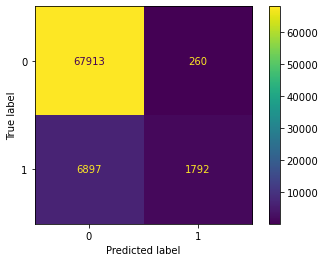

In [114]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_hat = first.predict(X_train)
cm = confusion_matrix(y_train, y_hat)
cmdis = ConfusionMatrixDisplay(cm)
cmdis.plot();

# Iterations

In [23]:
df['channel_id'] = df['channel_id'].astype(str)
df['video_id'] = df['video_id'].astype(str)

## Multinomial Bayes + Complement Bayes

In [22]:
from sklearn.metrics import recall_score, accuracy_score, make_scorer
from sklearn.model_selection import cross_validate

#Creates features and target then performs train test split
y = df['label']
X = df[['chats', 'channel_id', 'video_id', 'hour', 'day_night', 
            'any_emojis', 'cap_ratio', 'offset_percent', 'total_comments']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

count_vec = ColumnTransformer([
    ('cv', CountVectorizer(lowercase = False, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['channel_id', 'video_id', 'day_night'])],
    remainder = 'passthrough')

mnb_cv = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('mnb', MultinomialNB())
])

#Fits model and prints training score
mnb_cv.fit(X_train, y_train)
preds = mnb_cv.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", mnb_cv.score(X_train, y_train))
#Cross validates model and prints average result
scoring = {
    'acc': make_scorer(accuracy_score),
    'rec': 'recall'
}
scores = cross_validate(mnb_cv, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

In [156]:
tfidf_vec = ColumnTransformer([
    ('cv', TfidfVectorizer(lowercase = False, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['channel_id', 'video_id', 'day_night'])],
    remainder = 'passthrough')

mnb_tfidf = imbpipeline(steps=[
    ('preproc', tfidf_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('mnb', MultinomialNB())
])

#Fits model and prints training score
mnb_tfidf.fit(X_train, y_train)
preds = mnb_cv.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", mnb_cv.score(X_train, y_train))
#Cross validates model and prints average result
scores = cross_validate(mnb_tfidf, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 0.21377432125108797
Training Accuracy: 0.6216856183809946
Validation Recall:0.7881241747838456
Validation Accuracy:0.5588586920856187


In [159]:
from sklearn.naive_bayes import ComplementNB

cnb = imbpipeline(steps=[
    ('preproc', count_vec),
    ('mnb', ComplementNB())
])

#Fits model and prints training score
cnb.fit(X_train, y_train)
preds = cnb.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", cnb.score(X_train, y_train))
#Cross validates model and prints average result
scores = cross_validate(cnb, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 0.1985851298828398
Training Accuracy: 0.6064635320444433
Validation Recall:0.7808720112517581
Validation Accuracy:0.6130987245617645


### Grid Search

In [162]:
#Creates parameters to test
params = {
    'preproc__cv__max_features': [None, 4000, 8000],
    'preproc__cv__max_df': [.5, .8, 1],
    'preproc__cv__ngram_range': [(1,1), (2,2)]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(mnb_cv, param_grid = params, scoring = scoring, cv = 3, refit = 'rec')
search.fit(X_train, y_train)
search.best_params_

{'preproc__cv__max_df': 0.5,
 'preproc__cv__max_features': None,
 'preproc__cv__ngram_range': (1, 1)}

In [163]:
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(max_df = .5, lowercase = False, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['channel_id', 'video_id', 'day_night'])],
    remainder = 'passthrough')

mnb_tuned = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('mnb', MultinomialNB())
])

#Fits model and prints training score
mnb_tuned.fit(X_train, y_train)
preds = mnb_tuned.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", mnb_tuned.score(X_train, y_train))
#Cross validates model and prints average result
scores = cross_validate(mnb_tuned, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 0.21377432125108797
Training Accuracy: 0.6216856183809946
Validation Recall:0.8341574066897082
Validation Accuracy:0.597733555553152


## Logistic Regression

<AxesSubplot:>

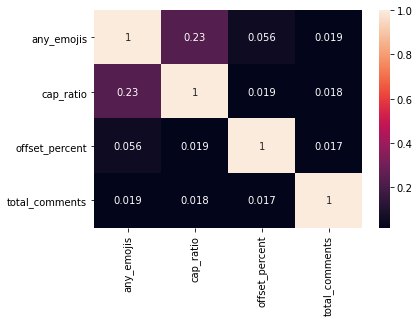

In [23]:
cont = df[['any_emojis', 'cap_ratio', 'offset_percent', 'total_comments']]
sns.heatmap(cont.corr().abs(), annot = True)

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, accuracy_score, make_scorer

#Get rid of channel_id + hour to avoid multicolinearity w/ video_id and day_night
y = df['label']
X = df[['chats', 'video_id', 'day_night', 
            'any_emojis', 'cap_ratio', 'offset_percent', 'total_comments']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

count_vec = ColumnTransformer([
    ('cv', CountVectorizer(lowercase = False, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['video_id', 'day_night']),
    ('ss', StandardScaler(), ['any_emojis', 'cap_ratio', 'offset_percent', 'total_comments'])],
    remainder = 'passthrough')

logreg = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('lr', LogisticRegression(max_iter = 10000, random_state = 213))
])

#Fits model and prints training score
logreg.fit(X_train, y_train)

preds = logreg.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", logreg.score(X_train, y_train))

#Cross validates model and prints average result
scores = cross_validate(logreg, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 0.8499794492396219
Training Accuracy: 0.9755274261603376
Validation Recall:0.8428202230109786
Validation Accuracy:0.9579746835443037


In [44]:
#Creates parameters to test
params = {
    'preproc__cv__max_features': [None, 4000, 8000],
    'preproc__cv__max_df': [.5, .8, 1],
    'preproc__cv__ngram_range': [(1,1), (2,2)],
    'preproc__cv__lowercase': [False, True]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(logreg, param_grid = params, scoring = scoring, cv = 3, refit = 'rec')
search.fit(X_train, y_train)
search.best_params_

{'preproc__cv__lowercase': True,
 'preproc__cv__max_df': 0.5,
 'preproc__cv__max_features': 8000,
 'preproc__cv__ngram_range': (1, 1)}

# FINAL MODEL

In [37]:
from sklearn.utils import class_weight

class_weight = class_weight.compute_class_weight('balanced', classes = np.unique(df.label), y = df.label)

In [ ]:
#Creates a new train test split with the added features
y = df['label']
X = df[['chats', 'video_id', 'day_night', 
            'any_emojis', 'cap_ratio', 'offset', 'total_comments']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

#Pipeline for processing and fitting model
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(lowercase = False, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['video_id', 'day_night']),
    ('ss', StandardScaler(), ['any_emojis', 'cap_ratio', 'offset', 'total_comments'])],
    remainder = 'passthrough')

logreg = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('lr', LogisticRegression(max_iter = 10000, random_state = 213))
])

#Fits model and prints training score
logreg.fit(X_train, y_train)
preds = logreg.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", logreg.score(X_train, y_train))

#Cross validates model and prints average result
scores = cross_validate(logreg, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, accuracy_score, make_scorer

#Get rid of channel_id + hour to avoid multicolinearity w/ video_id and day_night
y = df['label']
X = df[['chats', 'video_id', 'day_night', 
            'any_emojis', 'cap_ratio', 'offset', 'total_comments']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

count_vec = ColumnTransformer([
    ('cv', CountVectorizer(lowercase = True, max_df = .5, max_features = 8000, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['video_id', 'day_night']),
    ('ss', StandardScaler(), ['any_emojis', 'cap_ratio', 'offset', 'total_comments'])],
    remainder = 'passthrough')

logreg_tune = imbpipeline(steps=[
    ('preproc', count_vec),
    #('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('lr', LogisticRegression(class_weight = class_weight, max_iter = 10000, random_state = 213))
])

#Fits model and prints training score
logreg_tune.fit(X_train, y_train)
preds = logreg_tune.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", logreg_tune.score(X_train, y_train))

scoring = {
    'acc': make_scorer(accuracy_score),
    'rec': 'recall'
}

#Cross validates model and prints average result
scores = cross_validate(logreg_tune, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

/Users/kelseylane/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:679: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":


Training Recall: 0.9079730779187161
Training Accuracy: 0.9700486854917235


/Users/kelseylane/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:679: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":
/Users/kelseylane/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:679: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":
/Users/kelseylane/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:679: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":
/Users/kelseylane/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:679: FutureWarning: elementwise comparison failed; returning scalar inst

Validation Recall:0.7387042021485632
Validation Accuracy:0.9579746835443037


In [40]:
preds = logreg_tune.predict(X_test)
print("Training Recall:", recall_score(preds, y_test))
print("Training Accuracy:", logreg_tune.score(X_test, y_test))

Training Recall: 0.8456028651014723
Training Accuracy: 0.9559493670886076


#### Assumption test

<ipython-input-49-812980efa55c>:3: RuntimeWarning: divide by zero encountered in true_divide
  log_odds = np.log(pred / (1 - pred))
<ipython-input-49-812980efa55c>:3: RuntimeWarning: divide by zero encountered in log
  log_odds = np.log(pred / (1 - pred))


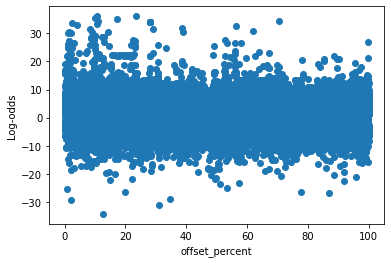

In [49]:
#Grabs probabilities and calculates log odds
pred = logreg_tune.predict_proba(X_train)[:, 0]
log_odds = np.log(pred / (1 - pred))
#Plots log odds versus continuous variable to check for linearity
plt.scatter(x = X_train['offset_percent'], y = log_odds)
plt.xlabel("offset_percent")
plt.ylabel("Log-odds")
plt.show()

In [88]:
words = logreg_tune.named_steps["preproc"].transformers_[0][1].get_feature_names()
ohe = logreg_tune.named_steps["preproc"].transformers_[1][1].get_feature_names()
numbers = logreg_tune.named_steps["preproc"].transformers_[2][2]

columns = [*words, *ohe, *numbers]

coef_dict = {}
for coef, feat in zip(logreg_tune['lr'].coef_[0, :], columns):
    coef_dict[feat] = coef

In [91]:
coef_dict

import heapq
heapq.nlargest(20, coef_dict, key = coef_dict.get)

['wtf',
 'rip',
 'kill',
 'feelsbadman',
 ':(',
 'hell',
 'damage',
 'dead',
 'lag',
 'damn',
 'ban',
 'shit',
 'no',
 'miss',
 'insane',
 'hate',
 'nasty',
 'suck',
 'bitch',
 'bomb']

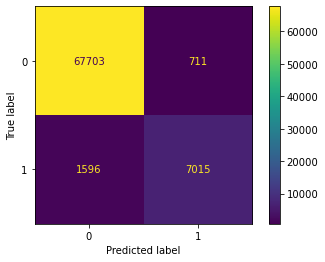

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_hat = logreg_tune.predict(X_train)
cm = confusion_matrix(y_train, y_hat)
cmdis = ConfusionMatrixDisplay(cm)
cmdis.plot();

## Random Forest

In [230]:
from sklearn.ensemble import RandomForestClassifier 
y = df['label']
X = df[['chats', 'channel_id', 'video_id', 'hour', 'day_night', 
            'any_emojis', 'cap_ratio', 'offset_percent', 'total_comments']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

count_vec = ColumnTransformer([
    ('cv', CountVectorizer(lowercase = False, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['channel_id', 'video_id', 'day_night'])],
    remainder = 'passthrough')

rfc = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('rf', RandomForestClassifier(random_state = 213))
])

#Fits model and prints training score
rfc.fit(X_train, y_train)
preds = rfc.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", rfc.score(X_train, y_train))
#Cross validates model and prints average result
scores = cross_validate(rfc, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 1.0
Training Accuracy: 1.0
Validation Recall:0.3858905179558423
Validation Accuracy:0.9256979978770259


In [239]:
#Creates parameters to test
params = {
    'rf__criterion': ['gini', 'entropy'],
    'rf__max_depth': [None, 50, 100],
    'rf__min_samples_split': [2, 5, 10]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(rfc, param_grid = params, scoring = scoring, cv = 3, refit = 'rec')
search.fit(X_train, y_train)
search.best_params_

{'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__min_samples_split': 10}

In [243]:
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(lowercase = False, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['channel_id', 'video_id', 'day_night'])],
    remainder = 'passthrough')

rfc_tune = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('rf', RandomForestClassifier(min_samples_split = 10, random_state = 213))
])

#Fits model and prints training score
rfc_tune.fit(X_train, y_train)
preds = rfc_tune.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", rfc_tune.score(X_train, y_train))
#Cross validates model and prints average result
scores = cross_validate(rfc_tune, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 0.9960725424511956
Training Accuracy: 0.998698966979782
Validation Recall:0.4344583766437246
Validation Accuracy:0.9297962645898616


In [238]:
words = rfc_tune.named_steps["preproc"].transformers_[0][1].get_feature_names()
ohe = rfc_tune.named_steps["preproc"].transformers_[1][1].get_feature_names()
numbers = ['hour', 'any_emojis', 'cap_ratio', 'offset_percent', 'total_comments']

columns = [*words, *ohe, *numbers]

for name, importance in zip(columns, rfc_tune['rf'].feature_importances_):
    print(name, importance)

no


0.038538826298286304

## SVM

In [ ]:
from sklearn.svm import SVC

count_vec = ColumnTransformer([
    ('cv', CountVectorizer(lowercase = False, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['channel_id', 'video_id', 'day_night']),
    ('ss', StandardScaler(), ['hour', 'any_emojis', 'cap_ratio', 'offset_percent', 'total_comments'])],
    remainder = 'passthrough')

svm_untune = imbpipeline(steps=[
    ('preproc', count_vec),
    ('smote', SMOTE(sampling_strategy = 'minority', random_state = 213)),
    ('svm', SVC(kernel='linear', gamma='auto'))
])

#Fits model and prints training score
svm_untune.fit(X_train, y_train)
preds = svm_untune.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", svm_untune.score(X_train, y_train))
#Cross validates model and prints average result
scores = cross_validate(svm_untune, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

# XGBoost

In [26]:
df.label.value_counts()

0    91441
1    11259
Name: label, dtype: int64

In [27]:
from xgboost import XGBClassifier

#Creates a new train test split with the added features
y = df['label']
X = df[['chats', 'video_id', 'day_night', 
            'any_emojis', 'cap_ratio', 'offset_percent', 'total_comments']]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 213)

#Pipeline for processing and fitting model
count_vec = ColumnTransformer([
    ('cv', CountVectorizer(lowercase = False, tokenizer = chat_tokenizer), 'chats'),
    ('ohe', OneHotEncoder(), ['video_id', 'day_night']),
    ('ss', StandardScaler(), ['any_emojis', 'cap_ratio', 'offset_percent', 'total_comments'])],
    remainder = 'passthrough')

xgb = imbpipeline(steps=[
    ('preproc', count_vec),
    ('xgb', XGBClassifier(scale_pos_weight = 8, random_state = 213))
])

#Fits model and prints training score
xgb.fit(X_train, y_train)
preds = xgb.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", xgb.score(X_train, y_train))

scoring = {
    'acc': make_scorer(accuracy_score),
    'rec': 'recall'
}

#Cross validates model and prints average result
scores = cross_validate(xgb, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 0.7497580384987633
Training Accuracy: 0.9508081791626095
Validation Recall:0.7750774360629501
Validation Accuracy:0.9403440441415125


In [38]:
params = {
    'xgb__learning_rate': [0.2, 0.25],
    'xgb__subsample': [0.7, 0.8],
    'xgb__n_estimators': [300, 400]
}

search = GridSearchCV(xgb_train, param_grid = params, scoring = scoring, cv = 3, refit = 'rec')
search.fit(X_train, y_train)
search.best_params_

{'xgb__learning_rate': 0.2, 'xgb__n_estimators': 400, 'xgb__subsample': 0.8}

In [ ]:
from sklearn.decomposition import TruncatedSVD

xgb_train = imbpipeline(steps=[
    ('preproc', count_vec),
    ('xgb', XGBClassifier(learning_rate = .2, max_depth = 10, min_child_weight = 2,
                          n_estimators = 400, subsample = .8, scale_pos_weight = 8, random_state = 213))
])

#Fits model and prints training score
xgb_train.fit(X_train, y_train)
preds = xgb_train.predict(X_train)
print("Training Recall:", recall_score(preds, y_train))
print("Training Accuracy:", xgb_train.score(X_train, y_train))

#Cross validates model and prints average result
scores = cross_validate(xgb_train, X_train, y_train, cv = 5, scoring = scoring)
print("Validation Recall:" + str(np.mean(scores['test_rec'])))
print("Validation Accuracy:" + str(np.mean(scores['test_acc'])))

Training Recall: 0.8514851485148515
Training Accuracy: 0.9762284972411555


# Final Test

In [32]:
#Test results for final model
preds = xgb_train.predict(X_test)
print("Test Recall:", recall_score(preds, y_test))
print("Test Accuracy:", xgb_train.score(X_test, y_test))

Test Recall: 0.740705734089477
Test Accuracy: 0.9494839337877312


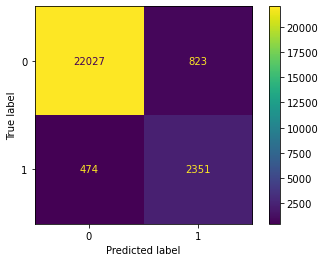

In [33]:
#Plts confusion matric for test data
cm = confusion_matrix(y_test, preds)
cmdis = ConfusionMatrixDisplay(cm)
cmdis.plot();